**Workshop:** Develpoing Deep Learning models using Pytorch <br>
**Topic:** Autograd <br>
**Author:** Arun Prakash A <br>

In [53]:
import torch
from torch import  tensor

In [1]:
# dir(torch.autograd.Function)

* In this article, whenever I say  `forward()` and `backward()`, I mean the forward and backward methods defined by subclassing `torch.autograd.Function`

* That is, **forward and backward** function defined for *a differentiable operation*.

# Computation Graph

Let's create a simple function
$$y=\sigma(x)$$

In [ ]:
x = tensor(1.0) # leaf variable
y = torch.sigmoid(x)
print(y)

tensor(0.7311)


Let's verify the presence of the following attributes whenever we create a tensor

  * data
  * grad 
  * grad_fn 
  * is_leaf 
  * requires_grad
  * backward

In [ ]:
print(x.data)
print(x.grad)
print(x.grad_fn)
print(x.requires_grad)
print(x.backward)

tensor(1.)
None
None
False
<bound method Tensor.backward of tensor(1.)>


In [ ]:
print(x.is_leaf, y.is_leaf)

True True


* All tensors that **we create** are leaf variables ( any tensor for which the `require_grad ` arg set to *False*  is considered a leaf variable by convention)
* $y$ (which is a function of $x$) is also a leaf variable.
* We know how to calculate the gradient of $y$ (a scalar function) evaluated  at $x=1.0$ <br>
$$\frac{\partial y}{ \partial x} = \sigma(1)(1-\sigma(1))=0.73*0.27=0.1971$$


In [ ]:
y.backward()

RuntimeError: ignored

OOPS, what happened? Let's look into the error message and the stack info. 

 * It seems that we didn't define something called **grad_fn**, **required_grad**. 
 * It means still we are using **ATen** and haven't tied it up with **Autograd**.
 * Also, notice that the exception occurs when it calls the torch AutoGrad object`Variable`, in `Variable._execution_engine.run_backward()` 

 * Let's make use of AutoGrad by setting `requires_grad=True` in the tensor `x`. <br>
 * Behind the screen, it wraps the tensor `x` into the `Variable` object. (That is, it binds the **Aten** to **Autograd**)
 * This will compute the gradient of the scalar function for the (scalar valued) tensor `y`.
  * Note: As of now, autograd requires **floating point Tensor types** ( half, float, double ,and bfloat16) and complex Tensor types (cfloat, cdouble).

In [3]:
x = tensor(1.0, requires_grad=True, dtype=torch.float64) # note the tensor has to be a float type to use autograd
y = torch.sigmoid(x)
print(y)

tensor(0.7311, dtype=torch.float64, grad_fn=<SigmoidBackward0>)


* $x$ is still a leaf variable, however, `requires_grad=True`
* Therefore, `y` is no longer a leaf variable as it is obtained some operation on $x$. It has a grad function (grad_fn) named `SigmoidBackward0` <br>
* If you print` x.grad_fn`, it will be `None`. This is because $x$ is a leaf node. Therefore, leaf nodes in the computational graph do not have grad_fn (That makes sense!)
* Let's compute the gradient by calling `backward()`

In [ ]:
print(x.is_leaf, y.is_leaf)

True False


In [ ]:
print(x.grad_fn)
print(y.grad_fn)

None


In [4]:
y.backward()

 * See the **accumulated** gradient using the `.grad` attribute of the tensor.

In [5]:
print('The gradient of y wrt x: ',x.grad)

The gradient of y wrt x:  tensor(0.1966, dtype=torch.float64)


* If we create a tensor, it becomes a leaf variable.
* When we explicitly set the argument `require gradients` to true, it gets attached to the graph.
* Differentiable operations (such as torch.mm, +,activation functions..) **can't** be a leaf node of the graph.
* (therefore, all variables (in NN)  that are learnable **parameters** ($\theta = [W_1,W_2,..,b_1,b_2..]$) form a leaf node  in the network)

A simple Composite function
$$y = \sigma(x)$$
$$z = 2*y$$


In [6]:
x = tensor(1,requires_grad=True, dtype=torch.float64)
y = torch.sigmoid(x)
z = 2*y

In [ ]:
print(x.is_leaf,y.is_leaf,z.is_leaf)

True False False


In [7]:
print(z)

tensor(1.4621, dtype=torch.float64, grad_fn=<MulBackward0>)


Accessing **grad_fn** attributes


In [ ]:
print(z.grad_fn._saved_other)
print(z.grad_fn._saved_self)
print(z.grad_fn.next_functions)

tensor(2)
None
((<SigmoidBackward0 object at 0x7f329d242d30>, 0), (None, 0))


In [ ]:
print(y.grad_fn._saved_result) # because it is a unary operation we don't have "saved_other, saved_self"
print(y.grad_fn.next_functions)

tensor(0.7311, dtype=torch.float64, grad_fn=<SigmoidBackward0>)
((<AccumulateGrad object at 0x7f321ff08460>, 0),)


Are $y$ and `y.grad_fn._saved_result` one and the same?

In [ ]:
print(y.grad_fn._saved_result.equal(y))
print(y.grad_fn._saved_result is y)

True
False


In [8]:
z.backward()

* Now the gradients would have been computed for each intermediate node. 
* However, we can access the gradient only for the leaf nodes (unless, we set **retain_grad**=True for other nodes)

$$\frac{\partial z}{\partial x}=\frac{\partial z}{\partial y}\frac{\partial y}{\partial x}$$
$$\frac{\partial z}{\partial x} = 2*\sigma(x)*(1-\sigma(x))=0.3942$$

In [ ]:
print(x.grad) # leaf node
print(z.grad) # non-leaf node
print(y.grad) # non-leaf node

tensor(0.3932, dtype=torch.float64)
None
None


<ipython-input-41-7bf8b86aeab0>:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  print(z.grad) # non-leaf node
<ipython-input-41-7bf8b86aeab0>:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30

What if I want to calculate the local gradient, $\frac{\partial y}{\partial x}$?
$$\frac{\partial y}{\partial x} = \sigma(x)*(1-\sigma(x))=0.73*0.7=0.19$$

In [9]:
x = tensor(1,requires_grad=True, dtype=torch.float64)
y = torch.sigmoid(x)
z = 2*y

In [10]:
y.backward()

In [11]:
print(x.grad)

tensor(0.1966, dtype=torch.float64)


What if we set $\frac{\partial z}{\partial z} = 2$?

In [ ]:
x = tensor(1,requires_grad=True, dtype=torch.float64)
y = torch.sigmoid(x)
y.backward(torch.tensor(2.0))
print(x.grad)

tensor(0.3932, dtype=torch.float64)


What if we retain the graph?

  * That is, executing the `y.backward() `more than one time.


In [55]:
x = tensor(1,requires_grad=True, dtype=torch.float64)
y = torch.sigmoid(x)

In [58]:
y.backward(retain_graph=True)
print(x.grad)

tensor(0.5898, dtype=torch.float64)


In [59]:
y.backward(retain_graph=False)

In [60]:
y.backward()

RuntimeError: ignored

Key Points:
* Computation graph does not create a copy of the tensors to store the results. Instead, they create a pointer to those tensors called **savedTensors**. 
* This  reduces the memory footprint and also manages the **scope of the tensors** when network really becomes deep.
* After calling `.backward()` method, the computation graph will be consumed.
* Therefore, trying backward second time will raise an error
* We can retain the graph by setting the arg `retain_graph=True`in `backward()`(It has it's use cases like in multi-task learning)

More about these at : https://pytorch.org/tutorials/intermediate/autograd_saved_tensors_hooks_tutorial.html

Very nice explantion: https://www.youtube.com/watch?v=MswxJw-8PvE 


# Hooks

 * How do we manipulate gradients while backpropagating?
 * How do we store the history of gradients for visualizing/debugging?
 
 Hook it!
 * They are a kind of event handlers (a callable). They will be called when a particular even occurs.
 * There are two type of hooks we can register: **Tensor** or **nn.Module**

 * Tensor hooks will be called when `.backward` is called from a tensor in the computation graph.

 * Module level hooks can be executed when both `forward `and `backward` get called. (Here `forward ` means a forward function in `torch.autograd.Function`)




 Official Documentation: https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html

 Nice Explanation at : https://www.youtube.com/watch?v=syLFCVYua6Q

In [61]:
x = tensor(1,requires_grad=True, dtype=torch.float64)
y = torch.sigmoid(x)
z = 2*y


 * Signature: hook(grad) --> Tensor or None
 * It is a callable object and takes in `Tensor.grad `as input (`.grad `is automatically passed to the hooks)

In [62]:
def y_hook(grad):
  print('Grad y wrt z is now',grad)
  

In [63]:
y.register_hook(y_hook)

In [64]:
z.backward()

Grad y wrt z is now tensor(2., dtype=torch.float64)


In [ ]:
y.grad

# A simple linear equation

In [65]:
x = torch.linspace(0,1,10)
y = torch.tensor(0.5)*x-0.1

* Observe that, in the following lines of code, `w` and `b` are leaf tensors and hence the gradient will get accumulated for each iteration (for different values of `x`)
$$\frac{\partial y}{\partial w}=x$$
$$\frac{\partial y}{\partial b}=1$$

* Therefore, computing gradients for a batch of inputs is straightforward.

In [66]:
w = torch.tensor(-0.5,requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)
print(w.grad,b.grad)
for i in range(len(x)):
  y_hat = w*x[i]+b
  y_hat.backward()
  print(w.grad,b.grad)


None None
tensor(0.) tensor(1.)
tensor(0.1111) tensor(2.)
tensor(0.3333) tensor(3.)
tensor(0.6667) tensor(4.)
tensor(1.1111) tensor(5.)
tensor(1.6667) tensor(6.)
tensor(2.3333) tensor(7.)
tensor(3.1111) tensor(8.)
tensor(4.) tensor(9.)
tensor(5.) tensor(10.)


What if we want to compute grad for each sample not for batch of samples?

In [22]:
w = torch.tensor(-0.5,requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)
print(w.grad,b.grad)
for i in range(len(x)):
  y_hat = w*x[i]+b
  y_hat.backward()
  print(w.grad,b.grad)
  w.grad = torch.tensor(0.0)
  b.grad = torch.tensor(0.0)
  

None None
tensor(0.) tensor(1.)
tensor(0.1111) tensor(1.)
tensor(0.2222) tensor(1.)
tensor(0.3333) tensor(1.)
tensor(0.4444) tensor(1.)
tensor(0.5556) tensor(1.)
tensor(0.6667) tensor(1.)
tensor(0.7778) tensor(1.)
tensor(0.8889) tensor(1.)
tensor(1.) tensor(1.)


Retaining the graph

In [18]:
w = torch.tensor(-0.5,requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)
print(w.grad,b.grad)
for i in range(len(x)):
  y_hat = w*x[i]+b
  y_hat.backward(retain_graph=True)
  print(w.grad,b.grad)

None None
tensor(0.) tensor(1.)
tensor(0.1111) tensor(2.)
tensor(0.3333) tensor(3.)
tensor(0.6667) tensor(4.)
tensor(1.1111) tensor(5.)
tensor(1.6667) tensor(6.)
tensor(2.3333) tensor(7.)
tensor(3.1111) tensor(8.)
tensor(4.) tensor(9.)
tensor(5.) tensor(10.)


* We need not to retain the graph unless we do backpropagate through multiple loss functions as in the case of multi-task learning.
* Setting `retain_graph=True` unnecessarily increases the memory foot print.

# Going beyond zero-dim Tensor

* Now let's change $x$ to a one dimensional tensor (that is, a vector)

In [71]:
x = tensor([0.5,0.25],requires_grad=True, dtype=torch.float64)
y = x**2+2*x+1
z = torch.tanh(y)
print(z)

tensor([0.9780, 0.9158], dtype=torch.float64, grad_fn=<TanhBackward0>)


In [72]:
z.backward()

RuntimeError: ignored

In [70]:
x.grad

tensor([0.1304], dtype=torch.float64)

In [ ]:
x = tensor([0.5,0.25],requires_grad=True, dtype=torch.float64)
y = x**2+2*x+1
z = torch.sum(torch.tanh(y)) 
#z = torch.mean(torch.tanh(y)) some reduction operation

print(z)

tensor(0.9469, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [ ]:
z.backward()

In [ ]:
print(x.grad)

tensor([0.0652, 0.2016], dtype=torch.float64)


# Gradient of Tensors

Let's say,

   $$y=Wx+b$$
where,
$x \in \mathbb{R}^n,\quad W \in \mathbb{R}^{m \times n}$. 
* Assume we follow denominator layout while computing gradients for tensors

In [27]:
torch.random.manual_seed(42)
x_bar = torch.tensor([[1],[2]],dtype=torch.float64,requires_grad=True) 
W = torch.randint(low=0,high=3,size=(2,2),dtype=torch.float64,requires_grad=True)
b = torch.randint(low=3,high=5,size=(2,1),dtype=torch.float64,requires_grad=True)

y = torch.matmul(W,x_bar)+b # since W requires grad, a_bar's requires_grad arg is set to True by default
y.retain_grad()

In [28]:
print(x_bar,'\n',W,'\n',b,'\n',y)

tensor([[1.],
        [2.]], dtype=torch.float64, requires_grad=True) 
 tensor([[0., 2.],
        [1., 1.]], dtype=torch.float64, requires_grad=True) 
 tensor([[3.],
        [4.]], dtype=torch.float64, requires_grad=True) 
 tensor([[7.],
        [7.]], dtype=torch.float64, grad_fn=<AddBackward0>)


$$L = \sum a$$
$$\frac{\partial L}{\partial a_i}=1$$

In [30]:
L = torch.sum(y)
L.retain_grad()
L.backward()

In [31]:
print(x_bar.grad)
print(y.grad)
print(L.grad)


tensor([[1.],
        [3.]], dtype=torch.float64)
tensor([[1.],
        [1.]], dtype=torch.float64)
tensor(1., dtype=torch.float64)


In [ ]:
torch.matmul(W.T,torch.tensor([[1],[1]],dtype=torch.float64))

tensor([[1.],
        [3.]], dtype=torch.float64, grad_fn=<MmBackward0>)

Backprop through a vector: Approach 2 
 * We summed `y` so that the result is a scalr. Therefore, we can call .*backward* method on the scalar.
 * the otherway of obtaining the same is to pass the **output gradient** (which is a vector) itself  to the `y.backward().`

In [32]:
torch.random.manual_seed(42)
x_bar = torch.tensor([[1],[2]],dtype=torch.float64,requires_grad=True) 
W = torch.randint(low=0,high=3,size=(2,2),dtype=torch.float64,requires_grad=True)
b = torch.randint(low=3,high=5,size=(2,1),dtype=torch.float64,requires_grad=True)
y = torch.matmul(W,x_bar) 

In [33]:
y.backward()

RuntimeError: ignored

In [34]:
y.backward(torch.ones_like(y))

In [35]:
print(x_bar.grad)

tensor([[1.],
        [3.]], dtype=torch.float64)


# Create a single sigmoid neuron and compute the gradients

Data:
 
  * Sample 100 data points from the following sigmoid function
  $$y = \frac{1}{1+exp(-(wx+b))}$$

In [73]:
x = torch.linspace(-1.0,1.0,10).reshape(10,1)
w = torch.randn(size=(1,10))
b = torch.tensor(1.0)
a = torch.matmul(w,x)+ b
y = 1/(1+torch.exp(-(a)))

In [39]:
print(y)

tensor([[0.8007]])


Model:

In [74]:
# parameter initialization
w = torch.randn(size=(1,10), requires_grad=True) # leaf tensor
b = torch.randn(size=(1,1), requires_grad=True)   # leaf tensor
eta = tensor(0.1) # leaf tensor but won't get grad
loss = []

for i in range(1):
  #forward prop
  a = torch.matmul(w,x)+b
  y_hat = 1/(1+torch.exp(-(a)))

  #compute loss
  L = torch.pow((y_hat-y),2)
  loss.append(L)

  # #backprop
  L.backward()
  print(w.grad)

tensor([[ 0.0509,  0.0396,  0.0283,  0.0170,  0.0057, -0.0057, -0.0170, -0.0283,
         -0.0396, -0.0509]])


* Now we have computed **w.grad** and **b.grad** 
* Let's try to update by re-assignment. 

  $$w = w - \eta \ (w.grad)$$

In [75]:
# data generation
x = torch.linspace(-1.0,1.0,10).reshape(10,1)
w = torch.randn(size=(1,10))
a = torch.matmul(w,x)+1
y = 1/(1+torch.exp(-(a)))

# parameter initialization
w = torch.randn(size=(1,10), requires_grad=True) # leaf tensor
b = torch.randn(size=(1,1), requires_grad=True)   # leaf tensor
eta = tensor(0.1) # leaf tensor but won't get grad
loss = []

epochs = 100

for i in range(2):
  #forward prop
  a = torch.matmul(w,x)+b
  y_hat = 1/(1+torch.exp(-(a)))

  #compute loss
  L = torch.pow((y_hat-y),2)
  loss.append(L)

  # #backprop
  L.backward()
  
  #update parameter
  print(f'iter:{i}, is_leaf:{w.is_leaf}')
  w = w - eta*w.grad
  b = b - eta*b.grad
 


iter:0, is_leaf:True
iter:1, is_leaf:False


<ipython-input-75-44d5c09999fb>:29: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  w = w - eta*w.grad


TypeError: ignored

* During the zeroth iteation, $w$ was a leaf tensor. Therefore, the weight got updated.
* As a side effect, $w$ becomes a non-leaf tensor due to re-assignment ( now $w$ is the result of some operartion on a leaf tensor)
* Therefore, we encounterd the problem when we try to update the parameter using re-assignment after the zeroth iteration

  $$w = w - \eta \ (w.grad)$$



**Solution:** 
* Disable computational graph momentarily using **context managaers**
* Notice that the parameter update is done using in_place methods `-= `instead of  `w = w- eta*w.grad` (which is costly for big networks)

In [ ]:
# Do NOT Execute this cell
with torch.set_grad_enabled(False):
  x = x - x.grad

with torch.no_grad():
  x = x - x.grad

In [76]:
# data generation
x = torch.linspace(-1.0,1.0,10).reshape(10,1)
w = torch.randn(size=(1,10))
a = torch.matmul(w,x)+1
y = 1/(1+torch.exp(-(a)))

# parameter initialization
w = torch.randn(size=(1,10), requires_grad=True) # leaf tensor
b = torch.randn(size=(1,1), requires_grad=True)   # leaf tensor
eta = tensor(0.1) # leaf tensor but won't get grad
loss = []

epochs = 100

for i in range(2):
  #forward prop
  a = torch.matmul(w,x)+b
  y_hat = 1/(1+torch.exp(-(a)))

  #compute loss
  L = torch.pow((y_hat-y),2)
  loss.append(L)

  # #backprop
  L.backward()
  
  #update parameter
  print(f'iter:{i}, is_leaf:{w.is_leaf}')
  with torch.no_grad():
    w -= eta*w.grad
    b -= eta*b.grad
  #Zero the gradients, otherwise it keeps accumulating
  w.grad.zero_()
  b.grad.zero_()

iter:0, is_leaf:True
iter:1, is_leaf:True


Now run **SGD** for 100 epochs

In [77]:
# data generation
x = torch.linspace(-1.0,1.0,10).reshape(10,1)

w = torch.randn(size=(1,10))
print('Actual w \n',w)
a = torch.matmul(w,x)+1
y = 1/(1+torch.exp(-(a)))

# parameter initialization
w = torch.randn(size=(1,10), requires_grad=True) # leaf tensor
b = torch.randn(size=(1,1), requires_grad=True)   # leaf tensor
eta = tensor(0.1) # leaf tensor but won't require grad
loss = []

epochs = 100

for i in range(epochs):
  #forward prop
  a = torch.matmul(w,x)+b
  y_hat = 1/(1+torch.exp(-(a)))

  #compute loss
  L = torch.pow((y_hat-y),2)
  loss.append(L.detach().item())

  # #backprop
  L.backward()
  
  #update parameter  
  with torch.no_grad():
    w -= eta*w.grad
    b -= eta*b.grad
  #Zero the gradients, otherwise it keeps accumulating
  w.grad.zero_()
  b.grad.zero_()

Actual w 
 tensor([[ 1.0651,  0.1997, -0.7579, -0.8966, -1.1916,  1.5229,  0.5082, -0.5818,
          1.3806, -0.3400]])


In [49]:
print(w)

tensor([[-0.7517, -0.7109,  1.4924,  1.0664, -0.1463, -0.3434, -2.1366,  0.4645,
          0.2172,  1.9495]], requires_grad=True)


In [78]:
import numpy as np
from matplotlib import pyplot as plt

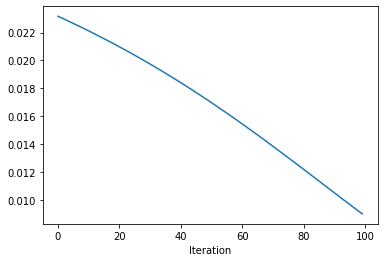

In [79]:
plt.plot(np.array(loss))
plt.xlabel('Iteration')
plt.show()

Add hook to track gradient

In [80]:
# data generation
x = torch.linspace(-1.0,1.0,10).reshape(10,1)

w = torch.randn(size=(1,10))
print('Actual w \n',w)
a = torch.matmul(w,x)+1
y = 1/(1+torch.exp(-(a)))

# parameter initialization
w = torch.randn(size=(1,10), requires_grad=True) # leaf tensor
b = torch.randn(size=(1,1), requires_grad=True)   # leaf tensor
eta = tensor(0.1) # leaf tensor but won't require grad
loss = []

epochs = 100

# track history of grad
a_grad = []
def a_hook(grad):
  a_grad.append(grad.detach().item())
  return grad

for i in range(epochs):
  #forward prop
  a = torch.matmul(w,x)+b
  a.register_hook(a_hook)
  y_hat = 1/(1+torch.exp(-(a)))

  #compute loss
  L = torch.pow((y_hat-y),2)
  loss.append(L.detach().item())

  # #backprop
  L.backward()
  
  #update parameter  
  with torch.no_grad():
    w -= eta*w.grad
    b -= eta*b.grad
  #Zero the gradients, otherwise it keeps accumulating
  w.grad.zero_()
  b.grad.zero_()

Actual w 
 tensor([[ 0.1806,  2.6024,  0.9387, -1.5747,  0.5691, -0.7668, -0.9221,  1.5614,
          0.6988,  0.0060]])


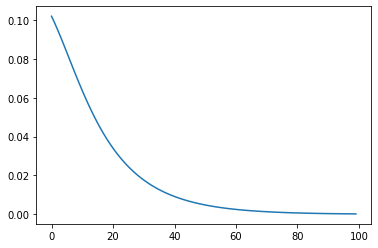

In [81]:
plt.plot(a_grad)
plt.show()

# Building NN

  * Now, we have all the tools to build a NN
  * Let's considet a simple binary classification problem
  

In [ ]:
from sklearn.datasets import make_circles
from matplotlib import pyplot as plt

num_samples = 1000

# Create circles
X, y = make_circles(num_samples,noise=0.001, random_state=42) 


In [ ]:
print(X[(0,),:].T.shape)

torch.Size([2, 1])


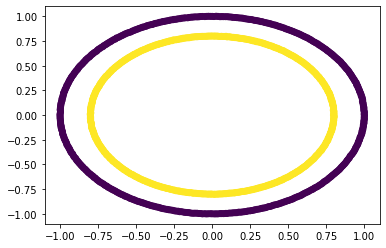

In [ ]:
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap='viridis');

In [ ]:
# change the data to tensor
X = torch.tensor(X,dtype=torch.float32)
y = torch.tensor(y,dtype=torch.float32)

# parameter initialization
W1 = torch.randn(size=(100,2), requires_grad=True)
b1 = torch.randn(size=(100,1), requires_grad=True)
W2 = torch.randn(size=(10,100), requires_grad=True)
b2 = torch.randn(size=(10,1), requires_grad=True)
W3 = torch.randn(size=(1,10), requires_grad=True)
b3 = torch.randn(size=(1,1), requires_grad=True)
eta = 0.1 
loss = []

epochs = 1000

for i in range(epochs):
  #forward prop
  a1 = torch.matmul(W1,X[(i,),:].T)+b1 # used (i,) to retain dim while accessing elements in X
  h1 = torch.sigmoid(a1)
  a2 = torch.matmul(W2,h1)+b2
  h2 = torch.sigmoid(a2)
  a3 = torch.matmul(W3,h2)+b3
  y_hat = torch.sigmoid(a3)
  
  #compute loss
  L = torch.pow((y_hat-y[i]),2)
  loss.append(L.detach().item())

  # #backprop
  
  L.backward()   
 
  with torch.no_grad():
    W1  -= eta*W1.grad   
    b1  -= eta*b1.grad  
    W2  -= eta*W2.grad   
    b2  -= eta*b2.grad   
    W3  -= eta*W3.grad   
    b3  -= eta*b3.grad  
  # zeroing out the gradients to avoid accumulaton from previous runs
  # w.grad = torch.zeros_like(w.grad)
  # b.grad = torch.zeros_like(b.grad)
  W1.grad.zero_()
  b1.grad.zero_()
  W2.grad.zero_()
  b2.grad.zero_()
  W3.grad.zero_()
  b3.grad.zero_()

<ipython-input-19-95cb1ecc1c5b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X,dtype=torch.float32)
<ipython-input-19-95cb1ecc1c5b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y,dtype=torch.float32)


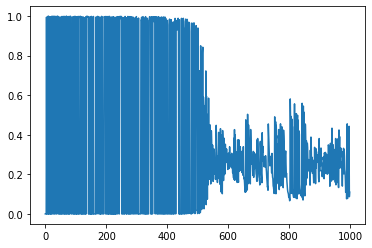

In [ ]:
plt.plot(loss)
plt.show()

#Batch GD

In [ ]:
# change the data to tensor
X = torch.tensor(X,dtype=torch.float32)
y = torch.tensor(y,dtype=torch.float32)

# parameter initialization
torch.manual_seed(0)
W1 = torch.randn(size=(10,2), requires_grad=True)
b1 = torch.randn(size=(10,1), requires_grad=True)
W2 = torch.randn(size=(5,10), requires_grad=True)
b2 = torch.randn(size=(5,1), requires_grad=True)
W3 = torch.randn(size=(1,5), requires_grad=True)
b3 = torch.randn(size=(1,1), requires_grad=True)
eta = 0.1 
loss = []

epochs = 100

for i in range(epochs):

    #forward prop
  acc_loss = 0
  for i in range(len(X)):
    a1 = torch.matmul(W1,X[(i,),:].T)+b1 # used (i,) to retain dim while accessing elements in X
    h1 = torch.sigmoid(a1)
    a2 = torch.matmul(W2,h1)+b2
    h2 = torch.sigmoid(a2)
    a3 = torch.matmul(W3,h2)+b3
    y_hat = torch.sigmoid(a3)
    L = (1/1000)*torch.pow((y_hat-y[i]),2) 
    acc_loss += L.detach().item()
    # backprop
    L.backward() 
    
    

  #compute loss   
  loss.append(acc_loss)
  with torch.no_grad():
    W1  -= eta*W1.grad   
    b1  -= eta*b1.grad  
    W2  -= eta*W2.grad   
    b2  -= eta*b2.grad   
    W3  -= eta*W3.grad   
    b3  -= eta*b3.grad  
  # zeroing out the gradients to avoid accumulaton from previous runs
  # w.grad = torch.zeros_like(w.grad)
  # b.grad = torch.zeros_like(b.grad)
  W1.grad.zero_()
  b1.grad.zero_()
  W2.grad.zero_()
  b2.grad.zero_()
  W3.grad.zero_()
  b3.grad.zero_()

<ipython-input-104-ea8f11849b68>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X,dtype=torch.float32)
<ipython-input-104-ea8f11849b68>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y,dtype=torch.float32)


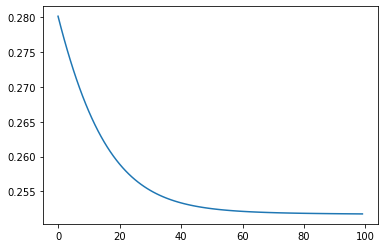

In [ ]:
plt.plot(loss)

# Visualize the decision regions

In [ ]:
def infer(x):
  with torch.no_grad():
    a1 = torch.matmul(W1,x.T)+b1 # used (i,) to retain dim while accessing elements in X
    h1 = torch.sigmoid(a1)
    a2 = torch.matmul(W2,h1)+b2
    h2 = torch.sigmoid(a2)
    a3 = torch.matmul(W3,h2)+b3
    y_hat = torch.sigmoid(a3)
  return y_hat

In [ ]:
import numpy as np

In [ ]:
x1 = np.linspace(-1,1,100)
x2 = np.linspace(-1,1,100)
xx,yy = np.meshgrid(x1,x2)
x_features = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

In [ ]:
x_features[1].shape

torch.Size([2])

In [ ]:
y_pred = np.zeros((10000,1))
for i in range(x_features.shape[0]):
  y_pred[i]=infer(x_features[(i,),:])

In [ ]:
y_pred = y_pred > 0.5

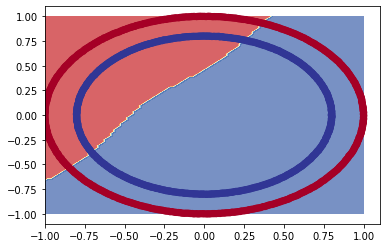

In [ ]:
plt.contourf(xx, yy, y_pred.reshape(xx.shape), cmap=plt.cm.RdYlBu, alpha=0.7)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)

#Important

   The computation graph is recreated from scratch **at every iteration**, and this is exactly what allows for using arbitrary Python control flow statements, that **can change** the overall shape and size of the graph **at every iteration**.

   This is called a **dynamic graph**. (Using static graph prohibits this kind of flexibility)

#References

 * https://pytorch.org/docs/stable/autograd.html
 * https://pytorch.org/docs/stable/notes/autograd.html
 * https://pytorch.org/tutorials/intermediate/autograd_saved_tensors_hooks_tutorial.html
 * https://www.youtube.com/watch?v=MswxJw-8PvE
 * https://pytorch.org/tutorials/intermediate/autograd_saved_tensors_hooks_tutorial.html

